#  Scotogenic Singlet Dark Matter

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import os, sys, inspect
import commands
from hep import *

In [3]:
def Lambda(LHA_out):
    '''Loop funtion, defined for each neutral triplet component
    The input must be a pyslha object'''
    mH0=LHA_out.blocks['MASS'][1001]
    mA0=LHA_out.blocks['MASS'][1002]
    Mk=np.asarray([LHA_out.blocks['MASS'][1012],LHA_out.blocks['MASS'][1014],LHA_out.blocks['MASS'][1016]])
    return ( Mk/(16*pi**2))*((mH0**2/(mH0**2-Mk**2))*np.log(mH0**2/Mk**2)\
                                    -(mA0**2/(mA0**2-Mk**2))*np.log(mA0**2/Mk**2) )/2. #Fix error! 

def run_official_idm(MHX,MH3,MHC,laL,la2,Mh,check=False):
    pd.Series({'MHX':MHX,'MH3':MH3,'MHC':MHC,'laL':laL,'la2':la2,'Mh':Mh}).to_csv('mo.dat',sep=' ')
    omegah2=-1
    if os.path.isfile('../micromegas/IDM/main'):
        mo=commands.getoutput("../micromegas/IDM/main mo.dat | grep -A10 'Omega='")
        if check:
            print "===Oficcial IDM output========"
            print mo
    else:
        print "Check IDM skipped"
        
    tmpo=mo.split('Omega=')
    if len(tmpo)>1:
        omegah2=eval(tmpo[1].split('\n')[0])
    return  omegah2

def phys_to_int(mH,mA,mHc,lambda_L,v):
    mH2=mH*mH;mA2=mA*mA;mHc2=mHc*mHc;v2=v*v
    lambda_5=(mH2-mA2)/v2
    mu2=mH2-lambda_L*v2
    lambda_3=2.*(mHc2-mu2)/v2
    lambda_4=-lambda_3-lambda_5+2*lambda_L
    return mu2,lambda_3,lambda_4,lambda_5

def run_official_idm_lha(spc,check=False):
    laL=(spc.blocks['MINPAR'][3]+spc.blocks['MINPAR'][4]+spc.blocks['MINPAR'][5])/2.
    MHX=spc.blocks['MASS'][1001];MH3=spc.blocks['MASS'][1002];MHC=spc.blocks['MASS'][1003]
    la2=spc.blocks['MINPAR'][2];Mh=spc.blocks['MASS'][25]
    return run_official_idm(MHX,MH3,MHC,laL,la2,Mh,check=check)

def int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v):
    v2=v*v
    tachyons=False
    mHc2=mu2+lambda_3*v2/2.
    if mHc2<0: tachyons=True
    mH2=mu2+(lambda_3+lambda_4+lambda_5)*v2/2.
    if mH2<0: tachyons=True
    mA2=mu2+(lambda_3+lambda_4-lambda_5)*v2/2.
    if mA2<0: tachyons=True
    if tachyons: print "Warning: Tachyionic masses"
    return np.sqrt(np.abs(np.array([mH2,mA2,mHc2]))),(lambda_3+lambda_4+lambda_5)/2 


## Check point with IDM official

In [4]:
a=CasasIbarra(MODEL='Scotogenic',func=Lambda,Yuk_key='YNIN')
v=a.vev


ipt=np.array([40,120,120,0.1])
mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt[0],ipt[1],ipt[2],ipt[3],v)

print 'expected:',ipt
print 'obtained:',int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v)
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
a=CasasIbarra(MODEL='Scotogenic',func=Lambda,Yuk_key='YNIN')
Mn1=900
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'

a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lambda_3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lambda_4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
a.LHA.blocks['MNIN'][2,2]='%0.8E       #Mn(2,2)' %1000
a.LHA.blocks['MNIN'][3,3]='%0.8E       #Mn(3,3)' %10000

a.LHA.blocks['MNIN'][1,1]='%0.8E       #Mn(1,1)' %Mn1

#h,U,Mnuin,phases=a.to_yukawas() #test Mnuin/0.9628#/0.968
spc=a.runSPheno()
mo=commands.getoutput("../micromegas/Scotogenic/CalcOmega LesHouches.in.Scotogenic | grep -A10 'Omega h^2'")
print "====micrOMEGAS SARAH: ======"
print mo
omhof=run_official_idm_lha(spc,check=True)

expected: [  4.00000000e+01   1.20000000e+02   1.20000000e+02   1.00000000e-01]
obtained: (array([  40.,  120.,  120.]), 0.10000000000000002)
====micrOMEGAS SARAH: ======
Xf=2.19e+01 Omega h^2=1.53e-01

# Channels which contribute to 1/(omega) more than 1%.
# Relative contributions in % are displayed
   83% ~etR ~etR ->d3 D3 
    8% ~etR ~etR ->e3 E3 
    5% ~etR ~etR ->g g 
    4% ~etR ~etR ->u2 U2 
===Oficcial IDM output========
Xf=2.19e+01 Omega=1.5024e-01
# Channels which contribute to 1/(omega) more than 1%.
# Relative contributions in % are displayed
   83% ~X ~X ->b B 
    8% ~X ~X ->l L 
    4% ~X ~X ->G G 
    4% ~X ~X ->c C 

==== Indirect detection =======
    Channel          vcs[cm^3/s]


In [39]:
a=CasasIbarra(MODEL='Scotogenic',func=Lambda,Yuk_key='YNIN')

In [40]:
ipt=pd.Series({'MHX':40,'MH3':120,'MHC':120,'lambda_L':0.1})
mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,a.vev)

a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'

a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda4Input' %lambda_3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda3Input' %lambda_4
a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
a.LHA.blocks['MNIN'][1,1]='%0.8E       #Mn(1,1)' %900
a.LHA.blocks['MNIN'][2,2]='%0.8E       #Mn(2,2)' %1000
a.LHA.blocks['MNIN'][3,3]='%0.8E       #Mn(3,3)' %10000

def xtoipt(x,lha,param={'block_name':'MNIN','block_key':(1,1)}):
    '''obtain LHA output from varible input'''
    block=param['block_name'];bkey=param['block_key']
    comment=lha.blocks[block][bkey].split('#')
    if len(comment)>1:
        comment=comment[1]
        lha.blocks[block][bkey]='%0.8E       # %s' %(x,comment)
        
    return lha

def x_to_int(x,lha,mH=ipt.MHX,mA=ipt.MH3,mHc=ipt.MHC):
    v=1/np.sqrt(np.sqrt(2)*a.G_F)
    mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,x,v)
    lha.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
    lha.blocks['MINPAR'][3]='%0.8E       #lambda4Input' %lambda_3
    lha.blocks['MINPAR'][4]='%0.8E       #lambda3Input' %lambda_4
    lha.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
    return lha



In [16]:
df=a.run_micromegas(xtoipt,npoints=1,CI=True)
df.Omega_h2

0    0.153
Name: Omega_h2, dtype: float64

In [19]:
df=a.run_micromegas(xtoipt,npoints=1,CI=True)
df.Omega_h2

0    0.153
Name: Omega_h2, dtype: float64

In [27]:
ipt.MH3=80.
df=a.run_micromegas(x_to_int,var_min=1E-2,var_max=0.1,npoints=1,CI=True)
df.Omega_h2

0    11.6
Name: Omega_h2, dtype: float64

In [48]:
ipt.MH3=42.
df=a.run_micromegas(x_to_int,var_min=1E-2,var_max=0.1,npoints=1,CI=True)
df.Omega_h2

0    0.000662
Name: Omega_h2, dtype: float64

In [51]:
ipt.MH3=42.
for i in range(1,4):
    for j in range(1,4):
        a.LHA.blocks['YNIN'][i,j]='%0.8E       # Yn(%d,%d)' %(0,i,j)
df=a.run_micromegas(x_to_int,var_min=1E-2,var_max=0.1,npoints=1,CI=False)
df.Omega_h2

0    0.000662
Name: Omega_h2, dtype: float64

In [53]:
run_official_idm_lha(a.LHA_out,check=True)

===Oficcial IDM output========
Xf=2.98e+01 Omega=6.7407e-04
# Channels which contribute to 1/(omega) more than 1%.
# Relative contributions in % are displayed
   15% ~H3 ~X ->d D 
   15% ~H3 ~X ->s S 
   15% ~H3 ~X ->b B 
   12% ~H3 ~X ->u U 
   12% ~H3 ~X ->c C 
    7% ~H3 ~X ->ne Ne 
    7% ~H3 ~X ->nm Nm 
    7% ~H3 ~X ->nl Nl 


0.00067407

In [11]:
df.Omega_h2

0    14900.000
1       98.200
2        0.153
Name: Omega_h2, dtype: float64

In [12]:
df=a.run_micromegas(xtoipt,param={'block_name':'MINPAR','block_key':5},var_min=-2E-1,var_max=-2,scale='lin',npoints=1,CI=True)

In [13]:
df.Omega_h2

0    0.102
Name: Omega_h2, dtype: float64

In [33]:
cat LesHouches.in.Scotogenic

BLOCK MODSEL
   1   1              #  1/0: High/low scale input 
   2   1              # Boundary Condition  
   6   1              # Generation Mixing 

BLOCK SMINPUTS
   2   1.166370E-05   # G_F,Fermi constant 
   3   1.187000E-01   # alpha_s(MZ) SM MSbar 
   4   9.118870E+01   # Z-boson pole mass 
   5   4.180000E+00   # m_b(mb) SM MSbar 
   6   1.735000E+02   # m_top(pole) 
   7   1.776690E+00   # m_tau(pole) 

BLOCK MINPAR
   1   2.6700000E-01  # lambda1Input
   2   1.00000000E-03       #   lambda2Input
   3   6.22271046E-01       #lambda4Input
   4   -2.11135523E-01       #lambda3Input
   5   NAN       # lambda5Input
   6   -4.46245686E+03       #mEt2Input

BLOCK SPHENOINPUT
   1   -1             # error level 
   2   0              # SPA conventions 
   11   1              # calculate branching ratios 
   13   1               # 3-Body decays: none (0), fermion (1), scalar (2), both (3)
   14   0              # Run couplings to scale of decaying particle 
   12   1.000E-15       

In [67]:
cat SPheno.spc.Scotogenic | grep -i -A30 'block mass'

Block MASS  # Mass spectrum
#   PDG code      mass          particle
        25     1.27227198E+02  # hh
      1001     4.00000000E+01  # etR
      1002     4.00757091E+01  # etI
      1003     4.00037889E+01  # etp
        23     9.11887000E+01  # VZ
        24     8.03497269E+01  # VWp
         1     5.00000000E-03  # Fd_1
         3     9.50000000E-02  # Fd_2
         5     4.18000000E+00  # Fd_3
         2     2.50000000E-03  # Fu_1
         4     1.27000000E+00  # Fu_2
         6     1.73500000E+02  # Fu_3
        11     5.10998930E-04  # Fe_1
        13     1.05658372E-01  # Fe_2
        15     1.77669000E+00  # Fe_3
        12     0.00000000E+00  # Fv_1
        14     0.00000000E+00  # Fv_2
        16     0.00000000E+00  # Fv_3
      1012    -1.00000000E+03  # Chi_1
      1014    -1.00000000E+03  # Chi_2
      1016    -1.00000000E+04  # Chi_3
Block ZXMIX Q=  1.60000000E+02  # ()
  1  1    -0.00000000E+00   # Real(ZX(1,1),dp)
  1  2     1.00000000E+00   # Real(ZX(1,2),dp)
  1  3 

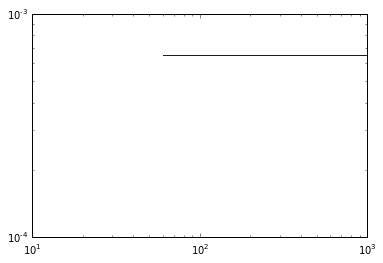

In [42]:
plt.loglog(df.Mn11, df.Omega_h2)

In [68]:
a.Series.lambda3+a.Series.lambda4+a.Series.lambda5

0.0

246.22056907348588

lambda_L= 0.1


array([  40.,  120.,  120.])

In [131]:
lambda_5

-0.21113552291137369

In [151]:
cat LesHouches.in.Scotogenic | grep -i -A10 'block minpar'

BLOCK MINPAR
   1   2.6700000E-01  # lambda1Input
   2   0.0000000E+00  # lambda2Input
   3   6.22271046E-01       #lambda3Input
   4   -2.11135523E-01       #lambda4Input
   5   -2.11135523E-01       #lambda5Input
   6   -4.46245686E+03       #mEt2Input

BLOCK SPHENOINPUT
   1   -1             # error level 
   2   0              # SPA conventions 


In [152]:
cat SPheno.spc.Scotogenic | grep -i -A22 'block mass'

Block MASS  # Mass spectrum
#   PDG code      mass          particle
        25     1.27227198E+02  # hh
      1001     4.00000000E+01  # etR
      1002     1.20000000E+02  # etI
      1003     1.20000000E+02  # etp
        23     9.11887000E+01  # VZ
        24     8.03497269E+01  # VWp
         1     5.00000000E-03  # Fd_1
         3     9.50000000E-02  # Fd_2
         5     4.18000000E+00  # Fd_3
         2     2.50000000E-03  # Fu_1
         4     1.27000000E+00  # Fu_2
         6     1.73500000E+02  # Fu_3
        11     5.10998930E-04  # Fe_1
        13     1.05658372E-01  # Fe_2
        15     1.77669000E+00  # Fe_3
        12     0.00000000E+00  # Fv_1
        14     0.00000000E+00  # Fv_2
        16     0.00000000E+00  # Fv_3
      1012    -9.00000000E+02  # Chi_1
      1014    -1.00000000E+03  # Chi_2
      1016    -1.00000000E+04  # Chi_3


In [126]:
cat SPheno.spc.Scotogenic

# SUSY Les Houches Accord 2 - Scotogenic Spectrum + Decays + Flavor Observables
# SPheno module generated by SARAH
# ----------------------------------------------------------------------
# SPheno v3.3.8  
#   W. Porod, Comput. Phys. Commun. 153 (2003) 275-315, hep-ph/0301101
#   W. Porod, F.Staub, Comput.Phys.Commun.183 (2012) 2458-2469, arXiv:1104.1573
# SARAH: 4.8.1   
#   F. Staub; arXiv:0806.0538 (online manual)
#   F. Staub; Comput. Phys. Commun. 181 (2010) 1077-1086; arXiv:0909.2863
#   F. Staub; Comput. Phys. Commun. 182 (2011)  808-833; arXiv:1002.0840
#   F. Staub; Comput. Phys. Commun. 184 (2013)  1792-1809; arXiv:1207.0906
#   F. Staub; Comput. Phys. Commun. 185 (2014)  1773-1790; arXiv:1309.7223 
# Including the calculation of flavor observables based on the FlavorKit 
#   W. Porod, F. Staub, A. Vicente; Eur.Phys.J. C74 (2014) 8, 2992; arXiv:1405.1434 
# Two-loop masss corrections to Higgs fields based on 
#   M. D. Goodsell, K. Nickel, F. Staub; arXiv:1411.0675 
#   M. D.

In [9]:
a.LHA.blocks['MNIN'][1,1]='%0.8E       #Mn(1,1)' %100

In [10]:
h,U,Mnuin,phases=a.to_yukawas() #test Mnuin/0.9628#/0.968
spc=a.runSPheno()

In [11]:
cat SPheno.spc.Scotogenic | grep -i -A22 'block mass'

Block MASS  # Mass spectrum
#   PDG code      mass          particle
        25     1.25064329E+02  # hh
      1001     4.98885413E+02  # etR
      1002     4.98886015E+02  # etI
      1003     4.98885869E+02  # etp
        23     9.11887000E+01  # VZ
        24     8.03497269E+01  # VWp
         1     5.00000000E-03  # Fd_1
         3     9.50000000E-02  # Fd_2
         5     4.18000000E+00  # Fd_3
         2     2.50000000E-03  # Fu_1
         4     1.27000000E+00  # Fu_2
         6     1.73500000E+02  # Fu_3
        11     5.10998930E-04  # Fe_1
        13     1.05658372E-01  # Fe_2
        15     1.77669000E+00  # Fe_3
        12     6.52870230E-18  # Fv_1
        14     8.80497553E-12  # Fv_2
        16     5.20275451E-11  # Fv_3
      1012    -1.00000020E+02  # Chi_1
      1014    -1.00000011E+03  # Chi_2
      1016    -1.00000060E+04  # Chi_3


In [13]:
Mnuin/0.9628#/0.968

array([[  6.40746293e-18,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   8.80330467e-12,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   5.20754912e-11]])

In [9]:
a.to_series()
a.Series

GFFermiconstant        0.000012
Mn11                 200.000000
Mn12                   0.000000
Mn13                   0.000000
Mn21                   0.000000
Mn22                1000.000000
Mn23                   0.000000
Mn31                   0.000000
Mn32                   0.000000
Mn34               10000.000000
Yn11                   0.000633
Yn12                  -0.000274
Yn13                  -0.000761
Yn21                  -0.000650
Yn22                  -0.001779
Yn23                  -0.000300
Yn31                  -0.002798
Yn32                   0.001065
Yn33                  -0.003183
Zbosonpolemass        91.188700
alphasMZSMMSbar        0.118700
lambda1                0.267000
lambda2                0.000000
lambda3                0.000000
lambda4                0.000000
lambda5               -0.000010
mEt2                 100.000000
mbmbSMMSbar            4.180000
mtaupole               1.776690
mtoppole             173.500000
dtype: float64

In [93]:
np.array([  3.09500960e-16+0.j,   8.50721938e-12+0.j ,  4.83825027e-11+0.j])/0.92

array([  3.36414087e-16+0.j,   9.24697759e-12+0.j,   5.25896768e-11+0.j])

In [23]:
Lambda(a.LHA_out)

0.0 0.0 [  -200.       -1000.00002 -10000.0036 ]


array([ nan,  nan,  nan])

In [25]:
cat SPheno.spc.Scotogenic

# SUSY Les Houches Accord 2 - Scotogenic Spectrum + Decays + Flavor Observables
# SPheno module generated by SARAH
# ----------------------------------------------------------------------
# SPheno v3.3.8  
#   W. Porod, Comput. Phys. Commun. 153 (2003) 275-315, hep-ph/0301101
#   W. Porod, F.Staub, Comput.Phys.Commun.183 (2012) 2458-2469, arXiv:1104.1573
# SARAH: 4.8.1   
#   F. Staub; arXiv:0806.0538 (online manual)
#   F. Staub; Comput. Phys. Commun. 181 (2010) 1077-1086; arXiv:0909.2863
#   F. Staub; Comput. Phys. Commun. 182 (2011)  808-833; arXiv:1002.0840
#   F. Staub; Comput. Phys. Commun. 184 (2013)  1792-1809; arXiv:1207.0906
#   F. Staub; Comput. Phys. Commun. 185 (2014)  1773-1790; arXiv:1309.7223 
# Including the calculation of flavor observables based on the FlavorKit 
#   W. Porod, F. Staub, A. Vicente; Eur.Phys.J. C74 (2014) 8, 2992; arXiv:1405.1434 
# Two-loop masss corrections to Higgs fields based on 
#   M. D. Goodsell, K. Nickel, F. Staub; arXiv:1411.0675 
#   M. D.

In [34]:
IF=_readSLHAFile_with_comments(spcfile,ignorenomass=True,ignorenobr=True)

NameError: name '_readSLHAFile_with_comments' is not defined

In [154]:
IF.blocks['YNIN'].entries[3,3]='1E-2  #Y[3,3]'

In [155]:
pyslha.writeSLHAFile('kk.spc',IF)

In [156]:
cat kk.spc

BLOCK MODSEL
   1   1              #  1/0: High/low scale input 
   2   1              # Boundary Condition  
   6   1              # Generation Mixing 

BLOCK SMINPUTS
   2   1.166370E-05   # G_F,Fermi constant 
   3   1.187000E-01   # alpha_s(MZ) SM MSbar 
   4   9.118870E+01   # Z-boson pole mass 
   5   4.180000E+00   # m_b(mb) SM MSbar 
   6   1.735000E+02   # m_top(pole) 
   7   1.776690E+00   # m_tau(pole) 

BLOCK MINPAR
   1   2.6700000E-01  # lambda1Input
   2   0.0000000E+00  # lambda2Input
   3   0.0000000E+00  # lambda3Input
   4   0.0000000E+00  # lambda4Input
   5   -1.0000000E-05 # lambda5Input
   6   1.0000000E+02  # mEt2Input

BLOCK SPHENOINPUT
   1   -1             # error level 
   2   0              # SPA conventions 
   11   1              # calculate branching ratios 
   13   1              # 3-Body decays: none (0), fermion (1), scalar (2), both (3) 
   14   0              # Run couplings to scale of decaying particle 
   12   1.000E-04      # write only branchin

In [88]:
IF=pyslha.readSLHAFile('SPheno.spc.4VL')
IF.blocks['EPSU'][ 1  , 1]

0.0

In [8]:
from hep import *
class fourVL(THDM):
    MESSAGE=THDM.MESSAGE+" with vectorlike quarks"
    def __init__(self, *args, **kwargs):
        super(fourVL, self).__init__(*args, **kwargs)
        self.MassQ=0.
        self.MassU=0.
        self.MassD=0.
        self.fd=0.
        self.fu=0.
        self.fdt=0.
        self.fut=0.
        if self.LHA.blocks.has_key('LAMQ'):
            for b in ['LAMQ','LAMD','LAMU']:
                for i in range(1,4):
                    self.LHA.blocks[b][i]='%.8E       # %s' %(0,b)
        else:
            print "Use hep.buildSLHA to include proper blocks" 
                
        

In [7]:
if 1==1:
    xd=pd.DataFrame()
    h=hep()
    h.MODEL='4VL'
    t=fourVL(['modsel','sminputs','minpar','sphenoinput','EPSUIN','EPSDIN','EPSEIN',\
                    'LAMQ','LAMD','LAMU'])
    
    
    t.m_h0=125.;t.m_H0=2000;t.m_A0=2100.26;t.m_Hp=2090.99
    
    t.tanb=-34.2325 #-???
    t.sab=-0.98 #np.sin(np.arctan(t.tanb)-np.arccos(cosa))
    t.lambdas[6]=0.;t.lambdas[7]=0.;t.m12_2=0
    
    t.MassQ=800.;t.MassU=1100.;t.MassD=1100.
    t.fd=0.;t.fu=2.3;t.fdt=0.;t.fut=1.6
    
    #Intialize output table
    ins=pd.Series({})
    #for t.m_h0 in np.linspace(100,2000.):
    for t.m_H0 in [2000]: #np.linspace(t.m_h0+10,2000.):
        #convert into general THDM basis
        perturbativity=t.phys_to_gen()
        #generate LHA input file
        for i in range(1,6):
            t.LHA.blocks['MINPAR'][i]='%.8E   # Lambda%dInput' %(t.lambdas[i],i)    
        t.LHA.blocks['MINPAR'][6]='%.8E    # TanBeta' %t.tanb
        t.LHA.blocks['MINPAR'][7]='%.8E    # MQInput' %t.MassQ  
        t.LHA.blocks['MINPAR'][8]='%.8E    # MUInput' %t.MassU  
        t.LHA.blocks['MINPAR'][9]='%.8E    # MDInput' %t.MassD   
        t.LHA.blocks['MINPAR'][10]='%.8E    # fdInput' %t.fd  
        t.LHA.blocks['MINPAR'][11]='%.8E    # fuInput' %t.fu 
        t.LHA.blocks['MINPAR'][12]='%.8E    # fdtInput' %t.fdt    
        t.LHA.blocks['MINPAR'][13]='%.8E    # futInput' %t.fut
        
        SPC=h.runSPheno(t.LHA) #Set paths and commands in h.config
        #reset branchings
        for p in [h.pdg.h0,h.pdg.H0]:
            h.Gamma[p]=0
            h.Br[p]={}
            h.Br[p][h.pdg.g,h.pdg.g]=0

        decays=h.branchings(SPC.decays) # -> h.Gamma[pdg], h.Br[pdg][pdg1,pdg2,...] 
                
        od=pd.Series({'$m_{h^0}$':SPC.blocks['MASS'][h.pdg.h0],'$m_{H^0}$':SPC.blocks['MASS'][h.pdg.H0],\
                    r'$\Gamma(h^0\to gg)$':h.Br[h.pdg.h0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.h0],\
                    r'$\Gamma(H^0\to gg)$':h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0],\
                    r'$\sigma(gg\to H^0)$':\
                      8*np.pi**2*h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0]/SPC.blocks['MASS'][h.pdg.H0]**3,\
                     'pert.':perturbativity})
        xs=ins.append(od)
        xd=xd.append(xs.to_dict(),ignore_index=True)

    xd.to_csv('thdm.csv',index=False)

In [9]:
xd

,$\Gamma(H^0\to gg)$,$\Gamma(h^0\to gg)$,$\sigma(gg\to H^0)$,$m_{H^0}$,$m_{h^0}$,pert.
0,15278.746823,0.025717,0.000151,2000,125.000002,False


In [40]:
if 1==1:
    xd=pd.DataFrame()
    h=hep()
    h.MODEL='4VL'
    t=fourVL(['modsel','sminputs','minpar','sphenoinput','EPSUIN','EPSDIN','EPSEIN',\
                    'LAMQ','LAMD','LAMU'])
    
    t.m_h0=125.;t.m_H0=2000;t.m_A0=2100.26;t.m_Hp=2090.99
    
    t.tanb=1. #-???
    t.sab=-0.98 #np.sin(np.arctan(t.tanb)-np.arccos(cosa))
    t.lambdas[6]=0.;t.lambdas[7]=0.;t.m12_2=0
    
    t.MassQ=800.;t.MassU=1100.;t.MassD=10000.
    t.fd=0.;t.fu=2.3;t.fdt=0.;t.fut=1.6
    
    #Intialize output table
    ins=pd.Series({})
    #for t.m_h0 in np.linspace(100,2000.):
    N=50
    m_H0=np.linspace(t.m_h0+10,2000.,N)
    for t.tanb in [0.25,1,-34.2325]:
     for ii in range(N):
        t.m_H0=m_H0[ii]
        if ii%10==0: print ii
        #convert into general THDM basis
        perturbativity=t.phys_to_gen()
        #generate LHA input file
        for i in range(1,6):
            t.LHA.blocks['MINPAR'][i]='%.8E   # Lambda%dInput' %(t.lambdas[i],i)    
        t.LHA.blocks['MINPAR'][6]='%.8E    # TanBeta' %t.tanb
        t.LHA.blocks['MINPAR'][7]='%.8E    # MQInput' %t.MassQ  
        t.LHA.blocks['MINPAR'][8]='%.8E    # MUInput' %t.MassU  
        t.LHA.blocks['MINPAR'][9]='%.8E    # MDInput' %t.MassD   
        t.LHA.blocks['MINPAR'][10]='%.8E    # fdInput' %t.fd  
        t.LHA.blocks['MINPAR'][11]='%.8E    # fuInput' %t.fu 
        t.LHA.blocks['MINPAR'][12]='%.8E    # fdtInput' %t.fdt    
        t.LHA.blocks['MINPAR'][13]='%.8E    # futInput' %t.fut
        
        SPC=h.runSPheno(t.LHA) #Set paths and commands in h.config
        #reset branchings
        for p in [h.pdg.h0,h.pdg.H0]:
            h.Gamma[p]=0
            h.Br[p]={}
            h.Br[p][h.pdg.g,h.pdg.g]=0

        decays=h.branchings(SPC.decays) # -> h.Gamma[pdg], h.Br[pdg][pdg1,pdg2,...] 
                
        od=pd.Series({'m_h0':SPC.blocks['MASS'][h.pdg.h0],'m_H0':SPC.blocks['MASS'][h.pdg.H0],\
                    'Gamma_h0_to_g_g':h.Br[h.pdg.h0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.h0],\
                    'Gamma_H0_to_g_g':h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0],\
                    'sigma_g_g_to_H0':8*np.pi**2*h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0]\
                      /SPC.blocks['MASS'][h.pdg.H0]**3*h.convert['pb/(1/GeV^2)'],\
                      'tanb':t.tanb,\
                     'pert.':perturbativity})
        xs=ins.append(od)
        xd=xd.append(xs.to_dict(),ignore_index=True)

    xd.to_csv('thdm.csv',index=False)

0
10
20
30
40
0
10
20
30
40
0
10
20
30
40


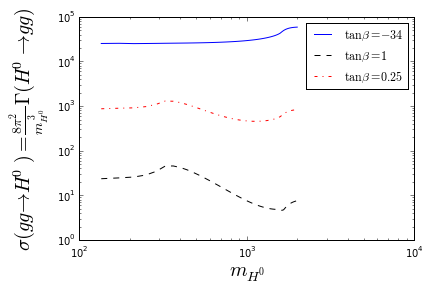

In [33]:
xl=xd[np.abs(xd.tanb)==np.abs(xd.tanb).max()]
xm=xd[xd.tanb==1]
xs=xd[xd.tanb==0.25]
plt.loglog(xl.m_H0,xl.sigma_g_g_to_H0,'b-',label=r'$\tan\beta=-34$')
plt.loglog(xm.m_H0,xm.sigma_g_g_to_H0,'k--',label=r'$\tan\beta=1$')
plt.loglog(xs.m_H0,xs.sigma_g_g_to_H0,'r-.',label=r'$\tan\beta=0.25$')
plt.legend(loc='best')
plt.xlabel(r'$m_{H^0}$',size=20)
plt.ylabel(r'$\sigma(gg\to H^0)=\frac{8\pi^2}{m_{H^0}^3}\Gamma(H^0\to gg)$ (pb)',size=20)

(100.0, 2000.0)

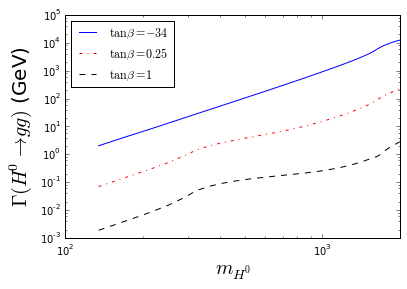

In [42]:
xl=xd[np.abs(xd.tanb)==np.abs(xd.tanb).max()]
xm=xd[xd.tanb==1]
xs=xd[xd.tanb==0.25]
plt.loglog(xl.m_H0,xl.Gamma_H0_to_g_g,'b-',label=r'$\tan\beta=-34$')
plt.loglog(xs.m_H0,xs.Gamma_H0_to_g_g,'r-.',label=r'$\tan\beta=0.25$')
plt.loglog(xm.m_H0,xm.Gamma_H0_to_g_g,'k--',label=r'$\tan\beta=1$')
plt.legend(loc='best')
plt.xlabel(r'$m_{H^0}$',size=20)
plt.ylabel(r'$\Gamma(H^0\to gg )$ (GeV)',size=20)
plt.xlim(1E2,2E3)

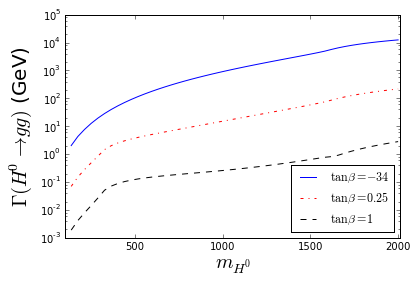

In [45]:
xl=xd[np.abs(xd.tanb)==np.abs(xd.tanb).max()]
xm=xd[xd.tanb==1]
xs=xd[xd.tanb==0.25]
plt.semilogy(xl.m_H0,xl.Gamma_H0_to_g_g,'b-',label=r'$\tan\beta=-34$')
plt.semilogy(xs.m_H0,xs.Gamma_H0_to_g_g,'r-.',label=r'$\tan\beta=0.25$')
plt.semilogy(xm.m_H0,xm.Gamma_H0_to_g_g,'k--',label=r'$\tan\beta=1$')
plt.legend(loc='best')
plt.xlabel(r'$m_{H^0}$',size=20)
plt.ylabel(r'$\Gamma(H^0\to gg )$ (GeV)',size=20)
plt.xlim(1E2,2010)
plt.savefig('gamma.pdf')

# 4VLNM

In [3]:
from hep import *
class fourVLNM(THDM):
    MESSAGE=THDM.MESSAGE+" with vectorlike quarks"
    def __init__(self, *args, **kwargs):
        super(fourVLNM, self).__init__(*args, **kwargs)
        self.MassQ=0.
        self.MassU=0.
        self.MassD=0.
        self.fd=0.
        self.fu=0.
        self.fdt=0.
        self.fut=0.
        self.pdg.UVL1=100008;self.pdg.UVL2=100010
        self.pdg.DVL1=100007;self.pdg.DVL2=100009


In [13]:
if 1==1:
    xd=pd.DataFrame()
    h=hep()
    h.MODEL='4VLNM8'
    t=fourVLNM(['modsel','sminputs','minpar','sphenoinput','EPSUIN','EPSDIN','EPSEIN'])
    
    t.m_h0=125.;t.m_H0=2000;t.m_A0=2100.26;t.m_Hp=2090.99
    
    t.tanb=1. #-???
    t.sab=-0.98 #np.sin(np.arctan(t.tanb)-np.arccos(cosa))
    t.lambdas[6]=0.;t.lambdas[7]=0.;t.m12_2=0
    
    t.MassQ=800.;t.MassU=1100.;t.MassD=300.
    t.fd=1.5;t.fu=2.3;t.fdt=2.;t.fut=1.6
    
    #Intialize output table
    ins=pd.Series({})
    #for t.m_h0 in np.linspace(100,2000.):
    N=50
    m_H0=np.linspace(t.m_h0+10,2000.,N)
    for t.tanb in [0.25]:#,1,-34.2325]:
      for t.MassQ in [800]:#,10000]:
        if t.MassQ==10000: 
            t.MassU=10000  
        for ii in range(N):
            t.m_H0=m_H0[ii]
            if ii%10==0: print ii
            #convert into general THDM basis
            perturbativity=t.phys_to_gen()
            #generate LHA input file
            for i in range(1,6):
                t.LHA.blocks['MINPAR'][i]='%.8E   # Lambda%dInput' %(t.lambdas[i],i)    
            t.LHA.blocks['MINPAR'][6]='%.8E    # TanBeta' %t.tanb
            t.LHA.blocks['MINPAR'][7]='%.8E    # MQInput' %t.MassQ  
            t.LHA.blocks['MINPAR'][8]='%.8E    # MUInput' %t.MassU  
            t.LHA.blocks['MINPAR'][9]='%.8E    # MDInput' %t.MassD   
            t.LHA.blocks['MINPAR'][10]='%.8E    # fdInput' %t.fd  
            t.LHA.blocks['MINPAR'][11]='%.8E    # fuInput' %t.fu 
            t.LHA.blocks['MINPAR'][12]='%.8E    # fdtInput' %t.fdt    
            t.LHA.blocks['MINPAR'][13]='%.8E    # futInput' %t.fut
        
            SPC=h.runSPheno(t.LHA) #Set paths and commands in h.config
            #reset branchings

        

            decays=h.branchings(SPC.decays) # -> h.Gamma[pdg], h.Br[pdg][pdg1,pdg2,...] 
            #t.fill_mixing_branchings(SPC.decays)
            for p in [h.pdg.h0,h.pdg.H0]:
                if not h.Br.has_key(p):
                    h.Gamma[p]=0
                    h.Br[p]={}
                for d in [(h.pdg.g,h.pdg.g),(h.pdg.Z0,h.pdg.Z0),(h.pdg.W_minus,h.pdg.W_plus),(h.pdg.W_plus,h.pdg.W_minus)]:
                    if not h.Br[p].has_key(d):
                        h.Br[p][d]=0
                
            od=pd.Series({'m_h0':SPC.blocks['MASS'][h.pdg.h0],'m_H0':SPC.blocks['MASS'][h.pdg.H0],\
                          'mQ':t.MassQ,'mU':t.MassU,'mD':t.MassD,\
                    'Gamma_h0_to_g_g':h.Br[h.pdg.h0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.h0],\
                    'Gamma_H0_to_g_g':h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0],\
                    'Gamma_H0_to_Z_Z':h.Br[h.pdg.H0][h.pdg.Z0,h.pdg.Z0],\
                    'Gamma_H0_to_W_W':h.Br[h.pdg.H0][h.pdg.W_minus,h.pdg.W_plus]\
                                     +h.Br[h.pdg.H0][h.pdg.W_plus,h.pdg.W_minus],\
                    'sigma_g_g_to_H0':8*np.pi**2*h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0]\
                      /SPC.blocks['MASS'][h.pdg.H0]**3*h.convert['pb/(1/GeV^2)'],\
                      'tanb':t.tanb,\
                     'pert.':perturbativity})
            xs=ins.append(od)
            xd=xd.append(xs.to_dict(),ignore_index=True)

    xd.to_csv('thdm.csv',index=False)

0
10
20
30
40


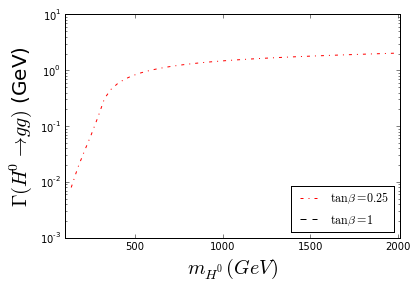

In [14]:
yd=xd[xd.mQ==800]
xl=yd[np.abs(yd.tanb)==np.abs(yd.tanb).max()]
xm=yd[yd.tanb==1]
xs=yd[yd.tanb==0.25]
plt.semilogy(xs.m_H0,xs.Gamma_H0_to_g_g,'r-.',label=r'$\tan\beta=0.25$')
plt.legend(loc='best')
plt.xlabel(r'$m_{H^0} (GeV)$',size=20)
plt.ylabel(r'$\Gamma(H^0\to gg )$ (GeV)',size=20)
plt.xlim(1E2,2010)
plt.savefig('gamma.pdf')

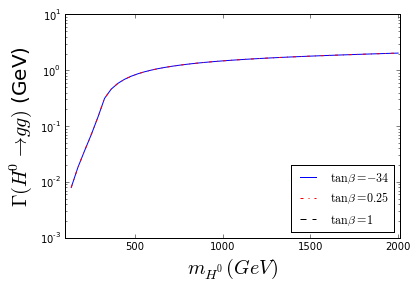

In [53]:
yd=xd[xd.mQ==800]
xl=yd[np.abs(yd.tanb)==np.abs(yd.tanb).max()]
xm=yd[yd.tanb==1]
xs=yd[yd.tanb==0.25]
plt.semilogy(xs.m_H0,xs.Gamma_H0_to_g_g,'r-.',label=r'$\tan\beta=0.25$')
plt.semilogy(xm.m_H0,xm.Gamma_H0_to_g_g,'k--',label=r'$\tan\beta=1$')
plt.legend(loc='best')
plt.xlabel(r'$m_{H^0} (GeV)$',size=20)
plt.ylabel(r'$\Gamma(H^0\to gg )$ (GeV)',size=20)
plt.xlim(1E2,2010)
plt.savefig('gamma.pdf')

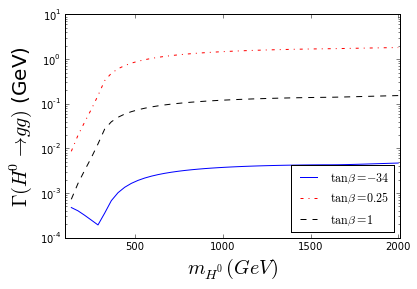

In [37]:
yd=xd[xd.mQ==800]
xl=yd[np.abs(yd.tanb)==np.abs(yd.tanb).max()]
xm=yd[yd.tanb==1]
xs=yd[yd.tanb==0.25]
plt.semilogy(xl.m_H0,xl.Gamma_H0_to_g_g,'b-',label=r'$\tan\beta=-34$')
plt.semilogy(xs.m_H0,xs.Gamma_H0_to_g_g,'r-.',label=r'$\tan\beta=0.25$')
plt.semilogy(xm.m_H0,xm.Gamma_H0_to_g_g,'k--',label=r'$\tan\beta=1$')
plt.legend(loc='best')
plt.xlabel(r'$m_{H^0} (GeV)$',size=20)
plt.ylabel(r'$\Gamma(H^0\to gg )$ (GeV)',size=20)
plt.xlim(1E2,2010)
plt.savefig('gamma.pdf')

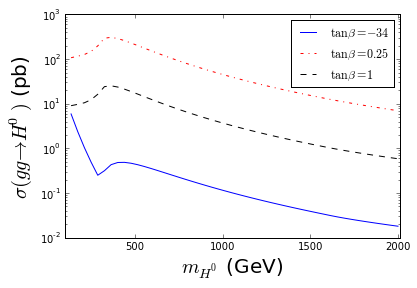

In [9]:
plt.semilogy(xl.m_H0,xl.sigma_g_g_to_H0,'b-',label=r'$\tan\beta=-34$')
plt.semilogy(xs.m_H0,xs.sigma_g_g_to_H0,'r-.',label=r'$\tan\beta=0.25$')
plt.semilogy(xm.m_H0,xm.sigma_g_g_to_H0,'k--',label=r'$\tan\beta=1$')
plt.legend(loc='best')
plt.xlabel(r'$m_{H^0}$ (GeV)',size=20)
plt.ylabel(r'$\sigma(gg \to H^0)$ (pb)',size=20)
plt.xlim(1E2,2010)
plt.savefig('sigma.pdf')

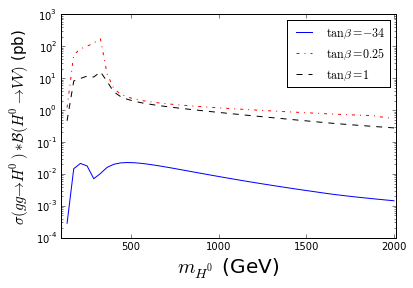

In [16]:
plt.semilogy(xl.m_H0,xl.sigma_g_g_to_H0*(xl.Gamma_H0_to_Z_Z+xl.Gamma_H0_to_W_W),'b-',label=r'$\tan\beta=-34$')
plt.semilogy(xs.m_H0,xs.sigma_g_g_to_H0*(xs.Gamma_H0_to_Z_Z+xs.Gamma_H0_to_W_W),'r-.',label=r'$\tan\beta=0.25$')
plt.semilogy(xm.m_H0,xm.sigma_g_g_to_H0*(xm.Gamma_H0_to_Z_Z+xm.Gamma_H0_to_W_W),'k--',label=r'$\tan\beta=1$')
plt.legend(loc='best')
plt.xlabel(r'$m_{H^0}$ (GeV)',size=20)
plt.ylabel(r'$\sigma(gg \to H^0)*{\cal B}(H^0\to VV)$ (pb)',size=15)
plt.xlim(1E2,2010)
plt.savefig('sigmabr.pdf')

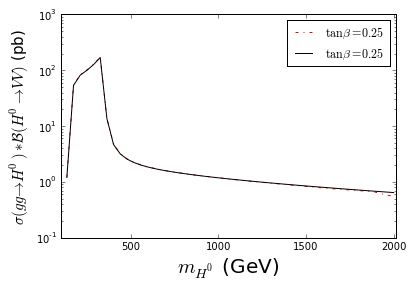

In [15]:
yd=xd[xd.mQ==10000]
ys=yd[yd.tanb==0.25]
plt.semilogy(xs.m_H0,xs.sigma_g_g_to_H0*(xs.Gamma_H0_to_Z_Z+xs.Gamma_H0_to_W_W),'r-.',label=r'$\tan\beta=0.25$')
plt.semilogy(ys.m_H0,ys.sigma_g_g_to_H0*(ys.Gamma_H0_to_Z_Z+ys.Gamma_H0_to_W_W),'k',label=r'$\tan\beta=0.25$')
plt.legend(loc='best')
plt.xlabel(r'$m_{H^0}$ (GeV)',size=20)
plt.ylabel(r'$\sigma(gg \to H^0)*{\cal B}(H^0\to VV)$ (pb)',size=15)
plt.xlim(1E2,2010)
plt.savefig('sigmabr.pdf')

In [24]:
if 1==1:
    xt=pd.DataFrame()
    h=hep()
    h.MODEL='THDMIII'
    t=THDM(['modsel','sminputs','minpar','sphenoinput','EPSUIN','EPSDIN','EPSEIN'])
    t.LHA.blocks['SPHENOINPUT'][525]='1              # Write loop contributions to diphoton decay of Higgs'
    
    t.m_h0=1.25E+02;t.m_H0=2088.3;t.m_A0=2100.26;t.m_Hp=2090.99
    
    t.tanb=0.25
    t.sab=-0.98 #np.sin(np.arctan(t.tanb)-np.arccos(cosa))
    t.lambdas[6]=0.;t.lambdas[7]=0.;t.m12_2=0.#;t.sab=-0.31

    
    #if perturbativity:
    ins=pd.Series({'m_A0':t.m_A0})
    ii=0
    for t.m_H0 in np.linspace(t.m_h0+10,2000.):
        ii=ii+1
        if ii%10==0: print ii
        #convert into general THDM basis
        perturbativity=t.phys_to_gen()
        #generate LHA input file
        for i in range(1,8):
            t.LHA.blocks['MINPAR'][i]='%.8E   # Lambda%dInput' %(t.lambdas[i],i)    
        t.LHA.blocks['MINPAR'][9]='%.8E    # M12input' %t.m12_2
        t.LHA.blocks['MINPAR'][10]='%.8E    # TanBeta' %t.tanb
        SPC=h.runSPheno(t.LHA)
        #reset breanchings
        for p in [h.pdg.h0,h.pdg.H0]:
            h.Gamma[p]=0
            h.Br[p]={}
            h.Br[p][h.pdg.g,h.pdg.g]=0

        decays=h.branchings(SPC.decays) # -> h.Gamma[pdg], h.Br[pdg][pdg1,pdg2,...] 
                
        od=pd.Series({'m_h0':SPC.blocks['MASS'][h.pdg.h0],'m_H0':SPC.blocks['MASS'][h.pdg.H0],\
                    'Gamma_h0_to_g_g':h.Br[h.pdg.h0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.h0],\
                    'Gamma_H0_to_g_g':h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0],\
                     'pert.':perturbativity})
        xs=ins.append(od)
        xt=xt.append(xs.to_dict(),ignore_index=True)

    xt.to_csv('thdm.csv',index=False)

10
20
30
40
50


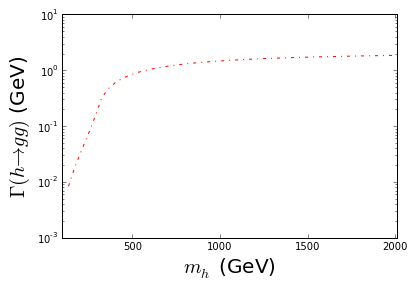

In [25]:
plt.semilogy(xt.m_H0,xt.Gamma_H0_to_g_g,'r-.')
plt.xlim(1E2,2010)
plt.xlabel(r'$m_h$ (GeV)',size=20)
plt.ylabel(r'$\Gamma(h\to gg)$ (GeV)',size=20) 

In [28]:
#from hep import *
if 1==1:
    xd=pd.DataFrame()
    h=hep()
    h.MODEL='SM'
    s=SM(['modsel','sminputs','minpar','sphenoinput'])
    t.LHA.blocks['SPHENOINPUT'][525]='1              # Write loop contributions to diphoton decay of Higgs'
    
    #if perturbativity:
    ins=pd.Series()
    ii=0
    for s.m_h0 in np.linspace(135,2000.):
    #for t.m_H0 in np.linspace(t.m_h0+10,2000.):
        ii=ii+1
        if ii%10==0: print ii
        #convert into general THDM basis
        perturbativity=s.phys_to_gen()
        #generate LHA input file
        s.LHA.blocks['MINPAR'][1]='%.8E   # LambdaIn' %s.lambda_sm    
        SPC=h.runSPheno(s.LHA)
        #reset breanchings
        for p in [h.pdg.h0]:
            h.Gamma[p]=0
            h.Br[p]={}
            h.Br[p][h.pdg.g,h.pdg.g]=0

        decays=h.branchings(SPC.decays) # -> h.Gamma[pdg], h.Br[pdg][pdg1,pdg2,...] 
                
        od=pd.Series({'m_h0':SPC.blocks['MASS'][h.pdg.h0],\
                    'Gamma_h0_to_g_g':h.Br[h.pdg.h0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.h0],\
                     'pert.':perturbativity})
        xs=ins.append(od)
        xd=xd.append(xs.to_dict(),ignore_index=True)

    xd.to_csv('thdm.csv',index=False)

10
20
30
40
50


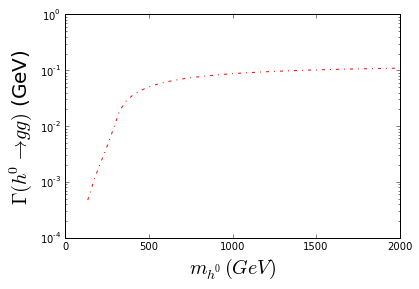

In [29]:
plt.semilogy(xd.m_h0,xd.Gamma_h0_to_g_g,'r-.',label=r'$\tan\beta=0.25$')
plt.xlabel(r'$m_{h^0} (GeV)$',size=20)
plt.ylabel(r'$\Gamma(h^0\to gg )$ (GeV)',size=20)

In [5]:
if 1==1:
    xd=pd.DataFrame()
    h=hep()
    h.MODEL='4VLNM'
    t=fourVLNM(['modsel','sminputs','minpar','sphenoinput','EPSUIN','EPSDIN','EPSEIN'])
    t.LHA.blocks['MODSEL'][12]='1800.          # Renormalization scale'
    t.LHA.blocks['SPHENOINPUT'][ 55]='0               # Calculate one loop masses'
    t.LHA.blocks['SPHENOINPUT'][ 14]='1               # Run couplings to scale of decaying particle'
    t.LHA.blocks['SPHENOINPUT'][525]='1              # Write loop contributions to diphoton decay of Higgs'
    t.m_h0=125.;t.m_H0=2000;t.m_A0=2100.26;t.m_Hp=2090.99
    
    t.tanb=1. #-???
    t.sab=-0.98 #np.sin(np.arctan(t.tanb)-np.arccos(cosa))
    t.lambdas[6]=0.;t.lambdas[7]=0.;t.m12_2=0
    
    t.MassQ=800.;t.MassU=1100.;t.MassD=2000.
    t.fd=0.;t.fu=2.3;t.fdt=0.;t.fut=1.6
    
    #Intialize output table
    ins=pd.Series({})
    #for t.m_h0 in np.linspace(100,2000.):
    N=50
    m_H0=np.linspace(t.m_h0+10,2000.,N)
    for t.tanb in [1]:#,1,-34.2325]:
      for t.MassQ in [800]:#,10000]:
        if t.MassQ==10000: 
            t.MassU=10000  
        for ii in range(N):
            t.m_H0=m_H0[ii]
            if ii%10==0: print ii
            #convert into general THDM basis
            perturbativity=t.phys_to_gen()
            #generate LHA input file
            for i in range(1,6):
                t.LHA.blocks['MINPAR'][i]='%.8E   # Lambda%dInput' %(t.lambdas[i],i)    
            t.LHA.blocks['MINPAR'][6]='%.8E    # TanBeta' %t.tanb
            t.LHA.blocks['MINPAR'][7]='%.8E    # MQInput' %t.MassQ  
            t.LHA.blocks['MINPAR'][8]='%.8E    # MUInput' %t.MassU  
            t.LHA.blocks['MINPAR'][9]='%.8E    # MDInput' %t.MassD   
            t.LHA.blocks['MINPAR'][10]='%.8E    # fdInput' %t.fd  
            t.LHA.blocks['MINPAR'][11]='%.8E    # fuInput' %t.fu 
            t.LHA.blocks['MINPAR'][12]='%.8E    # fdtInput' %t.fdt    
            t.LHA.blocks['MINPAR'][13]='%.8E    # futInput' %t.fut
        
            SPC=h.runSPheno(t.LHA) #Set paths and commands in h.config
            #reset branchings

        

            decays=h.branchings(SPC.decays) # -> h.Gamma[pdg], h.Br[pdg][pdg1,pdg2,...] 
            #t.fill_mixing_branchings(SPC.decays)
            for p in [h.pdg.h0,h.pdg.H0]:
                if not h.Br.has_key(p):
                    h.Gamma[p]=0
                    h.Br[p]={}
                for d in [(h.pdg.g,h.pdg.g),(h.pdg.Z0,h.pdg.Z0),(h.pdg.W_minus,h.pdg.W_plus),(h.pdg.W_plus,h.pdg.W_minus)]:
                    if not h.Br[p].has_key(d):
                        h.Br[p][d]=0
                
            od=pd.Series({'m_h0':SPC.blocks['MASS'][h.pdg.h0],'m_H0':SPC.blocks['MASS'][h.pdg.H0],\
                          'mQ':t.MassQ,'mU':t.MassU,'mD':t.MassD,\
                    'Gamma_h0_to_g_g':h.Br[h.pdg.h0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.h0],\
                    'Gamma_H0_to_g_g':h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0],\
                    'Gamma_H0_to_Z_Z':h.Br[h.pdg.H0][h.pdg.Z0,h.pdg.Z0],\
                    'Gamma_H0_to_W_W':h.Br[h.pdg.H0][h.pdg.W_minus,h.pdg.W_plus]\
                                     +h.Br[h.pdg.H0][h.pdg.W_plus,h.pdg.W_minus],\
                    'sigma_g_g_to_H0':8*np.pi**2*h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0]\
                      /SPC.blocks['MASS'][h.pdg.H0]**3*h.convert['pb/(1/GeV^2)'],\
                      'tanb':t.tanb,\
                     'pert.':perturbativity})
            xs=ins.append(od)
            xd=xd.append(xs.to_dict(),ignore_index=True)

    xd.to_csv('thdm.csv',index=False)

0
10
20
30
40


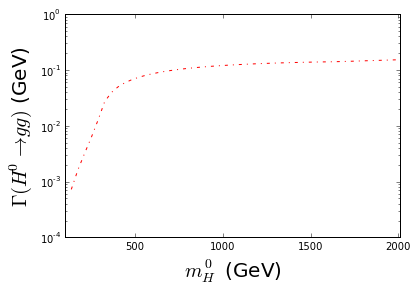

In [6]:
plt.semilogy(xd.m_H0,xd.Gamma_H0_to_g_g,'r-.')
plt.xlim(1E2,2010)
plt.xlabel(r'$m_H^0$ (GeV)',size=20)
plt.ylabel(r'$\Gamma(H^0\to gg)$ (GeV)',size=20) 

In [7]:
more LesHouches.in.4VLNM_low

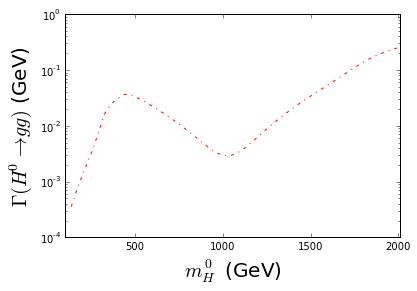

In [35]:
plt.semilogy(xd.m_H0,xd.Gamma_H0_to_g_g,'r-.')
plt.xlim(1E2,2010)
plt.xlabel(r'$m_H^0$ (GeV)',size=20)
plt.ylabel(r'$\Gamma(H^0\to gg)$ (GeV)',size=20) 

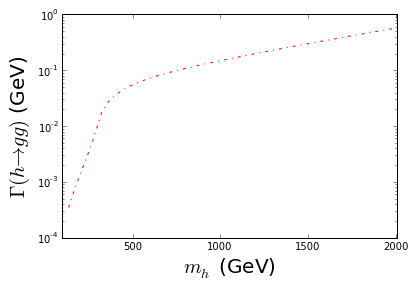

In [23]:
plt.semilogy(xd.m_H0,xd.Gamma_H0_to_g_g,'r-.')
plt.xlim(1E2,2010)
plt.xlabel(r'$m_H^0$ (GeV)',size=20)
plt.ylabel(r'$\Gamma(H^0\to gg)$ (GeV)',size=20) 

In [9]:
if 1==1:
    xd=pd.DataFrame()
    h=hep()
    h.MODEL='4VLNM'
    t=fourVLNM(['modsel','sminputs','minpar','sphenoinput','EPSUIN','EPSDIN','EPSEIN'])
    t.LHA.blocks['MODSEL'][12]='1800.          # Renormalization scale'
    t.LHA.blocks['SPHENOINPUT'][ 14]='1               # Run couplings to scale of decaying particle'
    t.LHA.blocks['SPHENOINPUT'][525]='1              # Write loop contributions to diphoton decay of Higgs'
    t.m_h0=125.;t.m_H0=1800;t.m_A0=2100.26;t.m_Hp=2090.99
    
    t.tanb=1. #-???
    t.sab=-0.98 #np.sin(np.arctan(t.tanb)-np.arccos(cosa))
    t.lambdas[6]=0.;t.lambdas[7]=0.;t.m12_2=0
    
    t.MassQ=800.;t.MassU=1100.;t.MassD=1100.
    t.fd=2.3;t.fu=2.3;t.fdt=1.6;t.fut=1.6
    
    #Intialize output table
    ins=pd.Series({})
    #for t.m_h0 in np.linspace(100,2000.):
    N=1#000
    MassQ=np.logspace(np.log10(500),np.log10(2500),N)
    for ii in range(N):
            t.MassQ=MassQ[ii]
            if ii%100==0: print ii
            t.fd=np.random.uniform(0.1,np.sqrt(4*np.pi))*np.random.choice([1,-1])
            t.fdt=np.random.uniform(0.1,np.sqrt(4*np.pi))*np.random.choice([1,-1])
            t.MassU=np.random.uniform(np.log10(500),np.log10(2500))
            t.MassD=t.MassU
            t.tanb=np.random.uniform(0.3,20)
            t.sab=np.random.uniform(0.9,1)*np.random.choice([1,-1])
            #convert into general THDM basis
            perturbativity=t.phys_to_gen()
            #generate LHA input file
            for i in range(1,6):
                t.LHA.blocks['MINPAR'][i]='%.8E   # Lambda%dInput' %(t.lambdas[i],i)    
            t.LHA.blocks['MINPAR'][6]='%.8E    # TanBeta' %t.tanb
            t.LHA.blocks['MINPAR'][7]='%.8E    # MQInput' %t.MassQ  
            t.LHA.blocks['MINPAR'][8]='%.8E    # MUInput' %t.MassU  
            t.LHA.blocks['MINPAR'][9]='%.8E    # MDInput' %t.MassD   
            t.LHA.blocks['MINPAR'][10]='%.8E    # fdInput' %t.fd  
            t.LHA.blocks['MINPAR'][11]='%.8E    # fuInput' %t.fu 
            t.LHA.blocks['MINPAR'][12]='%.8E    # fdtInput' %t.fdt    
            t.LHA.blocks['MINPAR'][13]='%.8E    # futInput' %t.fut
        
            SPC=h.runSPheno(t.LHA) #Set paths and commands in h.config
            #reset branchings

        

            decays=h.branchings(SPC.decays) # -> h.Gamma[pdg], h.Br[pdg][pdg1,pdg2,...] 
            #t.fill_mixing_branchings(SPC.decays)
            for p in [h.pdg.h0,h.pdg.H0]:
                if not h.Br.has_key(p):
                    h.Gamma[p]=0
                    h.Br[p]={}
                for d in [(h.pdg.g,h.pdg.g),(h.pdg.Z0,h.pdg.Z0),(h.pdg.W_minus,h.pdg.W_plus),(h.pdg.W_plus,h.pdg.W_minus)]:
                    if not h.Br[p].has_key(d):
                        h.Br[p][d]=0
                        
            od=pd.Series({'m_h0':SPC.blocks['MASS'][h.pdg.h0],'m_H0':SPC.blocks['MASS'][h.pdg.H0],\
                          'mQ':t.MassQ,'mU':t.MassU,'mD':t.MassD,\
                    'Gamma_h0_to_g_g':h.Br[h.pdg.h0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.h0],\
                    'Gamma_H0_to_g_g':h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0],\
                    'Gamma_H0_to_Z_Z':h.Br[h.pdg.H0][h.pdg.Z0,h.pdg.Z0],\
                    'Gamma_H0_to_W_W':h.Br[h.pdg.H0][h.pdg.W_minus,h.pdg.W_plus]\
                                     +h.Br[h.pdg.H0][h.pdg.W_plus,h.pdg.W_minus],\
                    'sigma_g_g_to_H0':8*np.pi**2*h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0]\
                      /SPC.blocks['MASS'][h.pdg.H0]**3*h.convert['pb/(1/GeV^2)'],\
                      'tanb':t.tanb,\
                     'RUL11':SPC.blocks['UUL4MIX'][1,1],'RUR11':SPC.blocks['UUR4MIX'][1,1],\
                     'RDL11':SPC.blocks['UDL4MIX'][1,1],'RUR11':SPC.blocks['UDR4MIX'][1,1],\
                     'MU1':SPC.blocks['MASS'][t.pdg.UVL1],'MU2':SPC.blocks['MASS'][t.pdg.UVL2],\
                     'MD1':SPC.blocks['MASS'][t.pdg.DVL1],'MU2':SPC.blocks['MASS'][t.pdg.DVL2],\
                     'pert.':perturbativity})
            xs=ins.append(od)
            xd=xd.append(xs.to_dict(),ignore_index=True)

    xd.to_csv('VL%G.csv' %G,index=False)

0


NameError: name 'G' is not defined

In [47]:
def fill_R(SPC,R=None,perturbativity=None):
    import pandas as pd
    if not R:
        R=''
    else:
        R=str(R)
    decays=h.branchings(SPC.decays) # -> h.Gamma[pdg], h.Br[pdg][pdg1,pdg2,...] 
    #t.fill_mixing_branchings(SPC.decays)
    for p in [h.pdg.h0,h.pdg.H0]:
        if not h.Br.has_key(p):
            h.Gamma[p]=0
            h.Br[p]={}
        for d in [(h.pdg.g,h.pdg.g),(h.pdg.Z0,h.pdg.Z0),(h.pdg.W_minus,h.pdg.W_plus),(h.pdg.W_plus,h.pdg.W_minus)]:
            if not h.Br[p].has_key(d):
                h.Br[p][d]=0
    xs=pd.Series({'m_h0'+R:SPC.blocks['MASS'][h.pdg.h0],'m_H0'+R:SPC.blocks['MASS'][h.pdg.H0],\
                  'mQ'+R:t.MassQ,'mU'+R:t.MassU,'mD'+R:t.MassD,\
            'Gamma_h0_to_g_g'+R:h.Br[h.pdg.h0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.h0],\
            'Gamma_H0_to_g_g'+R:h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0],\
            'Gamma_H0_to_Z_Z'+R:h.Br[h.pdg.H0][h.pdg.Z0,h.pdg.Z0],\
            'Gamma_H0_to_W_W'+R:h.Br[h.pdg.H0][h.pdg.W_minus,h.pdg.W_plus]\
                             +h.Br[h.pdg.H0][h.pdg.W_plus,h.pdg.W_minus],\
            'sigma_g_g_to_H0'+R:8*np.pi**2*h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0]\
              /SPC.blocks['MASS'][h.pdg.H0]**3*h.convert['pb/(1/GeV^2)'],\
              'tanb'+R:t.tanb,\
             'RUL11'+R:SPC.blocks['UUL4MIX'][1,1],'RUR11'+R:SPC.blocks['UUR4MIX'][1,1],\
             'RDL11'+R:SPC.blocks['UDL4MIX'][1,1],'RUR11'+R:SPC.blocks['UDR4MIX'][1,1],\
             'MU1'+R:SPC.blocks['MASS'][t.pdg.UVL1],'MU2'+R:SPC.blocks['MASS'][t.pdg.UVL2],\
             'MD1'+R:SPC.blocks['MASS'][t.pdg.DVL1],'MD2'+R:SPC.blocks['MASS'][t.pdg.DVL2],\
             'pert.'+R:perturbativity})                
    return xs

if 1==1:
    xd=pd.DataFrame()
    h=hep()
    h.MODEL='4VLNM'
    t=fourVLNM(['modsel','sminputs','minpar','sphenoinput','EPSUIN','EPSDIN','EPSEIN'])
    t.LHA.blocks['MODSEL'][12]='1800.          # Renormalization scale'
    t.LHA.blocks['SPHENOINPUT'][ 14]='1               # Run couplings to scale of decaying particle'
    t.LHA.blocks['SPHENOINPUT'][525]='1              # Write loop contributions to diphoton decay of Higgs'
    t.m_h0=125.;t.m_H0=1800;t.m_A0=2100.26;t.m_Hp=2090.99
    
    t.tanb=1. #-???
    t.sab=-0.98 #np.sin(np.arctan(t.tanb)-np.arccos(cosa))
    t.lambdas[6]=0.;t.lambdas[7]=0.;t.m12_2=0
    
    t.MassQ=800.;t.MassU=1100.;t.MassD=1100.
    t.fd=2.3;t.fu=2.3;t.fdt=1.6;t.fut=1.6
    
    #Intialize output table
    ins=pd.Series({})
    #for t.m_h0 in np.linspace(100,2000.):
    N=1000
    MassQ=np.logspace(np.log10(500),np.log10(2500),N)
    for ii in range(N):
            t.MassQ=MassQ[ii]
            if ii%100==0: print ii
            t.fu=np.random.uniform(0.1,np.sqrt(4*np.pi))#*np.random.choice([1,-1])
            t.fut=np.random.uniform(0.1,np.sqrt(4*np.pi))#*np.random.choice([1,-1])
            t.fd=t.fu
            t.fdt=t.fut
            t.MassU=np.random.uniform(np.log10(500),np.log10(2500))
            t.MassD=t.MassU
            t.tanb=np.random.uniform(0.3,20)
            t.sab=np.random.uniform(0.9,1)*np.random.choice([1,-1])
            #convert into general THDM basis
            perturbativity=t.phys_to_gen()
            #generate LHA input file
            for i in range(1,6):
                t.LHA.blocks['MINPAR'][i]='%.8E   # Lambda%dInput' %(t.lambdas[i],i)    
            t.LHA.blocks['MINPAR'][6]='%.8E    # TanBeta' %t.tanb
            t.LHA.blocks['MINPAR'][7]='%.8E    # MQInput' %t.MassQ  
            t.LHA.blocks['MINPAR'][8]='%.8E    # MUInput' %t.MassU  
            t.LHA.blocks['MINPAR'][9]='%.8E    # MDInput' %t.MassD   
            t.LHA.blocks['MINPAR'][10]='%.8E    # fdInput' %t.fd  
            t.LHA.blocks['MINPAR'][11]='%.8E    # fuInput' %t.fu 
            t.LHA.blocks['MINPAR'][12]='%.8E    # fdtInput' %t.fdt    
            t.LHA.blocks['MINPAR'][13]='%.8E    # futInput' %t.fut

            od=pd.Series()
            for G in [3,6,8]: #VectorLike Representation
                h.config['SPHENO_COMMAND']='SPheno4VLNM%d' %G
                SPC=h.runSPheno(t.LHA) #Set paths and commands in h.config
                od=od.append(fill_R(SPC,G,perturbativity))
        
            xs=ins.append(od)
            xd=xd.append(xs.to_dict(),ignore_index=True)

    xd.to_csv('VL%d.csv' %G,index=False)

0
100
200
300
400
500
600
700
800
900


In [48]:
print (xd.Gamma_H0_to_g_g8/xd.Gamma_H0_to_g_g3).min(),(xd.Gamma_H0_to_g_g8/xd.Gamma_H0_to_g_g3).max()
print (xd.Gamma_H0_to_g_g8/xd.Gamma_H0_to_g_g6).min(),(xd.Gamma_H0_to_g_g8/xd.Gamma_H0_to_g_g6).max()

0.866690252116 1.01235755411
1.0 1.0


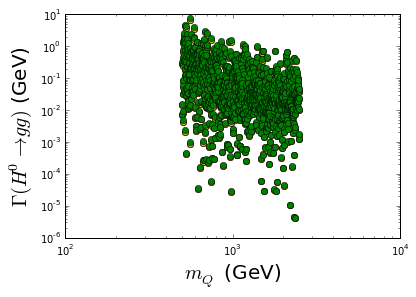

In [49]:
#xd=pd.loglog
plt.loglog(xd.mQ8,xd.Gamma_H0_to_g_g8,'ro')
plt.loglog(xd.mQ6,xd.Gamma_H0_to_g_g6,'yo')
plt.loglog(xd.mQ3,xd.Gamma_H0_to_g_g3,'go')
plt.xlabel(r'$m_Q$ (GeV)',size=20)
plt.ylabel(r'$\Gamma(H^0\to gg)$ (GeV)',size=20)

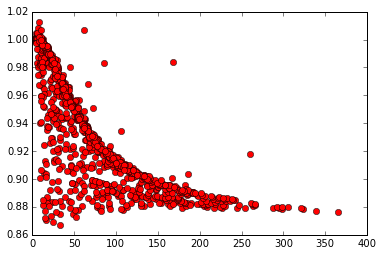

In [50]:
plt.plot(xd.MU18,xd.Gamma_H0_to_g_g8/xd.Gamma_H0_to_g_g3,'ro')

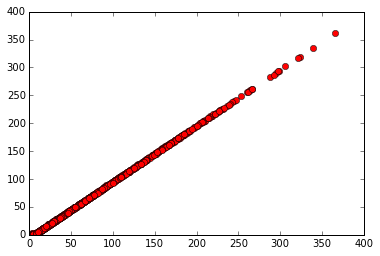

In [51]:
plt.plot(xd.MU18,xd.MD18,'ro')

In [33]:
c=a.append(pd.Series({2:2}))

In [37]:
c

1    1
2    2
dtype: int64

In [7]:
more SPheno.spc.4VLNM

In [20]:
SPC.blocks['MASS'][t.pdg.DVL2]

2578.25778

In [31]:
if 1==1:
    xd=pd.DataFrame()
    h=hep()
    #h.config['SPHENO_LHA_INPUT']='LesHouches.in.4VLNM'
    h.MODEL='4VLNM'
    t=fourVLNM(['modsel','sminputs','minpar','sphenoinput','EPSUIN','EPSDIN','EPSEIN'])
    #t.LHA.blocks['MODSEL'][1]='1              #  1/0: High/low scale input'
    t.LHA.blocks['MODSEL'][12]='2200.          # Renormalization scale'
    #t.LHA.blocks['SPHENOINPUT'][ 55]='0               # Calculate one loop masses'
    t.LHA.blocks['SPHENOINPUT'][525]='1              # Write loop contributions to diphoton decay of Higgs'
    t.LHA.blocks['SPHENOINPUT'][ 14]='1               # Run couplings to scale of decaying particle'
    t.m_h0=125.;t.m_H0=2000;t.m_A0=2100.26;t.m_Hp=2090.99
    
    t.tanb=1. #-???
    t.sab=-0.98 #np.sin(np.arctan(t.tanb)-np.arccos(cosa))
    t.lambdas[6]=0.;t.lambdas[7]=0.;t.m12_2=0
    
    t.MassQ=800.;t.MassU=1100.;t.MassD=1100.
    t.fd=-2.3;t.fu=2.3;t.fdt=-1.6;t.fut=1.6
    
    #Intialize output table
    ins=pd.Series({})
    #for t.m_h0 in np.linspace(100,2000.):
    N=1
    m_H0=np.ones(N)*2000 #np.linspace(t.m_h0+10,200,N)
    MassQ=np.linspace(t.MassQ,t.MassQ,1)
    MassU=np.linspace(t.MassU,t.MassU,1)
    for ii in range(N):
            t.m_H0=m_H0[ii]
            t.MassQ=np.random.choice(MassQ)
            t.MassU=np.random.choice(MassU)
            if ii%10==0: print ii
            #convert into general THDM basis
            perturbativity=t.phys_to_gen()
            #generate LHA input file
            for i in range(1,6):
                t.LHA.blocks['MINPAR'][i]='%.8E   # Lambda%dInput' %(t.lambdas[i],i)    
            t.LHA.blocks['MINPAR'][6]='%.8E    # TanBeta' %t.tanb
            t.LHA.blocks['MINPAR'][7]='%.8E    # MQInput' %t.MassQ  
            t.LHA.blocks['MINPAR'][8]='%.8E    # MUInput' %t.MassU  
            t.LHA.blocks['MINPAR'][9]='%.8E    # MDInput' %t.MassD   
            t.LHA.blocks['MINPAR'][10]='%.8E    # fdInput' %t.fd  
            t.LHA.blocks['MINPAR'][11]='%.8E    # fuInput' %t.fu 
            t.LHA.blocks['MINPAR'][12]='%.8E    # fdtInput' %t.fdt    
            t.LHA.blocks['MINPAR'][13]='%.8E    # futInput' %t.fut
        
            SPC=h.runSPheno(t.LHA) #Set paths and commands in h.config
            #reset branchings

        

            decays=h.branchings(SPC.decays) # -> h.Gamma[pdg], h.Br[pdg][pdg1,pdg2,...] 
            #t.fill_mixing_branchings(SPC.decays)
            for p in [h.pdg.h0,h.pdg.H0]:
                if not h.Br.has_key(p):
                    h.Gamma[p]=0
                    h.Br[p]={}
                for d in [(h.pdg.g,h.pdg.g),(h.pdg.Z0,h.pdg.Z0),(h.pdg.W_minus,h.pdg.W_plus),(h.pdg.W_plus,h.pdg.W_minus)]:
                    if not h.Br[p].has_key(d):
                        h.Br[p][d]=0
                        
            od=pd.Series({'m_h0':SPC.blocks['MASS'][h.pdg.h0],'m_H0':SPC.blocks['MASS'][h.pdg.H0],\
                          'mQ':t.MassQ,'mU':t.MassU,'mD':t.MassD,\
                    'Gamma_h0_to_g_g':h.Br[h.pdg.h0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.h0],\
                    'Gamma_H0_to_g_g':h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0],\
                    'Gamma_H0_to_Z_Z':h.Br[h.pdg.H0][h.pdg.Z0,h.pdg.Z0],\
                    'Gamma_H0_to_W_W':h.Br[h.pdg.H0][h.pdg.W_minus,h.pdg.W_plus]\
                                     +h.Br[h.pdg.H0][h.pdg.W_plus,h.pdg.W_minus],\
                    'sigma_g_g_to_H0':8*np.pi**2*h.Br[h.pdg.H0][h.pdg.g,h.pdg.g]*h.Gamma[h.pdg.H0]\
                      /SPC.blocks['MASS'][h.pdg.H0]**3*h.convert['pb/(1/GeV^2)'],\
                      'tanb':t.tanb,\
                     'pert.':perturbativity})
            xs=ins.append(od)
            xd=xd.append(xs.to_dict(),ignore_index=True)

    xd.to_csv('thdm.csv',index=False)

0


In [27]:
SPC.blocks['GAUGE'][3]**2/(4*np.pi)

0.08228173068808352

In [25]:
SPC.blocks['GAUGE'][3]**2/(4*np.pi)

0.08228173068808352

In [25]:
SPC.blocks['GAUGE']

GAUGE (Q=1000.0) { 1 :  0.362; 2 :  0.671; 3 :  1.06 }

In [45]:
1.02656433E+00**2/(4*np.pi)

0.08386147090267795

In [35]:
1.21**2/(4*np.pi)

0.11650937609042199

In [7]:
from hep import *

In [32]:
more SPheno.spc.4VLNM

In [9]:
more ../SPHENO/4VLNM/LesHouches.in.4VLNM

In [ ]:
Block MODSEL      #  
1 1               #  1/0: High/low scale input 
2 1              # Boundary Condition  
6 1               # Generation Mixing

In [5]:
np.logspace(np.log10(100),np.log10(2000),10)

array([  100.        ,   139.4950794 ,   194.58877176,   271.44176166,
         378.64790094,   528.19519005,   736.80629973,  1027.8085328 ,
        1433.74232887,  2000.        ])

In [29]:
if 1==1:
    xd=pd.DataFrame()
    h=hep()
    #h.config['SPHENO_LHA_INPUT']='LesHouches.in.4VLNM'
    h.MODEL='SM'
    t=SM(['modsel','sminputs','minpar','sphenoinput'])
    #t.LHA.blocks['MODSEL'][1]='1              #  1/0: High/low scale input'
    t.LHA.blocks['MODSEL'][12]='2200.          # Renormalization scale'
    #t.LHA.blocks['SPHENOINPUT'][ 55]='0               # Calculate one loop masses'
    t.LHA.blocks['SPHENOINPUT'][525]='1              # Write loop contributions to diphoton decay of Higgs'
    t.LHA.blocks['SPHENOINPUT'][ 14]='1               # Run couplings to scale of decaying particle'
    t.m_h0=125.;
    
    #Intialize output table
    ins=pd.Series({})
    #for t.m_h0 in np.linspace(100,2000.):
    N=1
    m_h0=np.ones(N)*125 #np.linspace(t.m_h0+10,200,N)
    
    for ii in range(N):
            t.m_h0=m_h0[ii]
            if ii%10==0: print ii
            #convert into general THDM basis
            perturbativity=t.phys_to_gen()
            #generate LHA input file
        
            SPC=h.runSPheno(t.LHA) #Set paths and commands in h.config
            #reset branchings



0


In [30]:
SPC.blocks['GAUGE'][3]**2/(4*np.pi)

0.08228173068808352

In [50]:
def loadurl(url, *args, **kwargs):
    import pandas as pd
    import urllib
    from StringIO import StringIO
    fp2 = urllib.urlopen(url)
    return pd.read_csv(StringIO(fp2.read()),*args, **kwargs)

In [51]:
loadurl('http://fisica.udea.edu.co/4VL/scan3_new_good.dat',sep='\t',names=['cos[tLL]','sin[tLL]','cos[tRR]','sin[tRR]','YY', 'Ytildee',\
                                          'mQQ','mUU','mXX12','mXX21', 'm11', 'm22', 'Y11', 'Y22',\
                                          'Cos[alphaa - betaa]',  'sin[alphaa - betaa]', 'Cos[alpha00]', 'Tan[betaa]',\
                                          'BRWWW', 'BRZZZ', '\[CapitalGamma]Tott', 'sigmaVLL',  'sigmaVLL BRWWW', 'alphastrong'])

,cos[tLL],sin[tLL],cos[tRR],sin[tRR],YY,Ytildee,mQQ,mUU,mXX12,mXX21,...,Cos[alphaa - betaa],sin[alphaa - betaa],Cos[alpha00],Tan[betaa],BRWWW,BRZZZ,\[CapitalGamma]Tott,sigmaVLL,sigmaVLL BRWWW,alphastrong
0,0.504515,0.863403,0.490893,0.871220,3.327680,2.945963,1141.676520,1547.313209,368.177321,325.943817,...,0.173624,0.984812,-0.650149,1.215318,0.667429,0.332571,85.384272,0.251273,0.167707,0.084189
1,-0.979383,-0.202010,-0.979910,-0.199443,3.384926,3.478845,2483.671526,947.297728,324.097046,333.089547,...,0.196687,0.980466,-0.710796,1.519058,0.646129,0.321958,113.187263,0.201247,0.130031,0.084256
2,-0.986915,-0.161239,-0.988177,-0.153318,3.014791,3.346353,2291.744744,824.505981,227.260042,252.253705,...,0.131789,0.991278,-0.836528,2.082333,0.448163,0.223314,73.263478,0.295052,0.132231,0.084449
3,0.177469,0.984126,0.164557,0.986368,2.778410,2.376206,694.243962,1921.989634,236.868685,202.579450,...,0.197928,0.980217,-0.757798,1.780982,0.455468,0.226954,162.600356,0.291921,0.132961,0.084761
4,-0.988739,-0.149652,-0.991508,-0.130043,1.932758,2.549193,1570.804903,524.110976,130.099914,171.594119,...,0.194942,0.980815,-0.829211,2.385795,0.466775,0.232588,153.910513,0.218461,0.101972,0.085440
5,-0.930023,-0.367502,-0.901415,-0.432955,2.852431,1.507764,1271.843222,822.121849,317.902269,168.039727,...,0.156882,0.987617,-0.658426,1.200491,0.254723,0.126925,182.660681,0.465327,0.118529,0.085061
6,0.553717,0.832705,0.558970,0.829188,2.870125,3.047770,1052.550593,1252.583768,235.456096,250.029597,...,0.211863,0.977299,-0.762233,1.872284,0.641002,0.319403,132.377680,0.438815,0.281281,0.084647
7,0.300049,0.953924,0.296854,0.954923,2.217588,2.113013,846.701382,1270.137718,150.304849,143.216900,...,0.242723,0.970096,-0.799115,2.366523,0.562676,0.280374,197.937585,0.252917,0.142310,0.084956
8,0.322790,0.946470,0.306420,0.951896,3.241764,2.630310,969.674898,1524.401319,228.063318,185.046606,...,0.089662,0.995972,-0.874844,2.264164,0.667429,0.332571,22.770858,0.244351,0.163087,0.084423
9,0.331320,0.943518,0.385062,0.922891,2.147728,3.323774,884.870648,1635.587030,265.297648,410.568437,...,0.124994,0.992157,-0.610636,0.993595,0.192143,0.095742,153.715946,0.523439,0.100575,0.084545


In [48]:
xd

In [44]:
import urllib
from StringIO import StringIO
fp2 = urllib.urlopen('http://fisica.udea.edu.co/4VL/scan3_new_good.dat')
pd.read_csv(StringIO(fp2.read()), sep='\t',names=['cos[tLL]','sin[tLL]','cos[tRR]','sin[tRR]','YY', 'Ytildee',\
                                          'mQQ','mUU','mXX12','mXX21', 'm11', 'm22', 'Y11', 'Y22',\
                                          'Cos[alphaa - betaa]',  'sin[alphaa - betaa]', 'Cos[alpha00]', 'Tan[betaa]',\
                                          'BRWWW', 'BRZZZ', '\[CapitalGamma]Tott', 'sigmaVLL',  'sigmaVLL BRWWW', 'alphastrong'])

,cos[tLL],sin[tLL],cos[tRR],sin[tRR],YY,Ytildee,mQQ,mUU,mXX12,mXX21,...,Cos[alphaa - betaa],sin[alphaa - betaa],Cos[alpha00],Tan[betaa],BRWWW,BRZZZ,\[CapitalGamma]Tott,sigmaVLL,sigmaVLL BRWWW,alphastrong
0,0.504515,0.863403,0.490893,0.871220,3.327680,2.945963,1141.676520,1547.313209,368.177321,325.943817,...,0.173624,0.984812,-0.650149,1.215318,0.667429,0.332571,85.384272,0.251273,0.167707,0.084189
1,-0.979383,-0.202010,-0.979910,-0.199443,3.384926,3.478845,2483.671526,947.297728,324.097046,333.089547,...,0.196687,0.980466,-0.710796,1.519058,0.646129,0.321958,113.187263,0.201247,0.130031,0.084256
2,-0.986915,-0.161239,-0.988177,-0.153318,3.014791,3.346353,2291.744744,824.505981,227.260042,252.253705,...,0.131789,0.991278,-0.836528,2.082333,0.448163,0.223314,73.263478,0.295052,0.132231,0.084449
3,0.177469,0.984126,0.164557,0.986368,2.778410,2.376206,694.243962,1921.989634,236.868685,202.579450,...,0.197928,0.980217,-0.757798,1.780982,0.455468,0.226954,162.600356,0.291921,0.132961,0.084761
4,-0.988739,-0.149652,-0.991508,-0.130043,1.932758,2.549193,1570.804903,524.110976,130.099914,171.594119,...,0.194942,0.980815,-0.829211,2.385795,0.466775,0.232588,153.910513,0.218461,0.101972,0.085440
5,-0.930023,-0.367502,-0.901415,-0.432955,2.852431,1.507764,1271.843222,822.121849,317.902269,168.039727,...,0.156882,0.987617,-0.658426,1.200491,0.254723,0.126925,182.660681,0.465327,0.118529,0.085061
6,0.553717,0.832705,0.558970,0.829188,2.870125,3.047770,1052.550593,1252.583768,235.456096,250.029597,...,0.211863,0.977299,-0.762233,1.872284,0.641002,0.319403,132.377680,0.438815,0.281281,0.084647
7,0.300049,0.953924,0.296854,0.954923,2.217588,2.113013,846.701382,1270.137718,150.304849,143.216900,...,0.242723,0.970096,-0.799115,2.366523,0.562676,0.280374,197.937585,0.252917,0.142310,0.084956
8,0.322790,0.946470,0.306420,0.951896,3.241764,2.630310,969.674898,1524.401319,228.063318,185.046606,...,0.089662,0.995972,-0.874844,2.264164,0.667429,0.332571,22.770858,0.244351,0.163087,0.084423
9,0.331320,0.943518,0.385062,0.922891,2.147728,3.323774,884.870648,1635.587030,265.297648,410.568437,...,0.124994,0.992157,-0.610636,0.993595,0.192143,0.095742,153.715946,0.523439,0.100575,0.084545


In [38]:
pd.read_csv(names=)

In [40]:
['cos[tLL]','sin[tLL]','cos[tRR]','sin[tRR]','YY', 'Ytildee',\
                                          'mQQ','mUU','mXX12','mXX21', 'm11', 'm22', 'Y11', 'Y22',\
                                          'Cos[alphaa - betaa]',  'sin[alphaa - betaa]', 'Cos[alpha00]', 'Tan[betaa]',\
                                          'BRWWW', 'BRZZZ', '\[CapitalGamma]Tott', 'sigmaVLL',  'sigmaVLL BRWWW', 'alphastrong']

['cos[tLL]',
 'sin[tLL]',
 'cos[tRR]',
 'sin[tRR]',
 'YY',
 'Ytildee',
 'mQQ',
 'mUU',
 'mXX12',
 'mXX21',
 'm11',
 'm22',
 'Y11',
 'Y22',
 'Cos[alphaa - betaa]',
 'sin[alphaa - betaa]',
 'Cos[alpha00]',
 'Tan[betaa]',
 'BRWWW',
 'BRZZZ',
 '\\[CapitalGamma]Tott',
 'sigmaVLL',
 'sigmaVLL BRWWW',
 'alphastrong']

In [1]:
from hep import *

In [2]:
hep.convert

{'USAGE': '(N [A])*1=(N [A])*convert[B/A] -> (N [B])',
 'm/(1/GeV)': 1.973269718e-16,
 'm^2/pb': 1e-40,
 'pb/(1/GeV^2)': 389379337.99758005,
 's/(1/GeV)': 6.58211899e-25}

In [3]:
50/hep.convert['pb/(1/GeV^2)'] #GeV^{-2}*

1.2840948432736495e-07

In [8]:
50./1000./hep.convert['pb/(1/GeV^2)']*8*(2000**3)/np.pi**2 #GeV

0.8326784603488537

In [10]:
0.05/hep.convert['pb/(1/GeV^2)']*8*(2000**3)/np.pi**2 

0.8326784603488537

In [11]:
cat .git/config

[core]
	repositoryformatversion = 0
	filemode = true
	bare = false
	logallrefupdates = true


sigma*Br=sigma*Gamma_h/Gamma_ToT